In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data import load_categories, load_hills, load_glove_model, load_word_frequency, load_nelson

HILLS_DATA_PATH = '../data/hills.csv'
REBA_CATEGORIES_PATH = '../data/reba_categories.csv'
WORD_FREQ_PATH = '../data/word_frequency.csv'
GLOVE_PATH = '../data/glove/glove.6B.300d.txt'
NELSON_PATHS = ['../data/nelson_a1.csv', '../data/nelson_a2.csv']

hills_csv = load_hills(HILLS_DATA_PATH)
reba_categories = load_categories(REBA_CATEGORIES_PATH)
word_freq = load_word_frequency(WORD_FREQ_PATH)
nelson = load_nelson(NELSON_PATHS, reba_categories.keys())
glove_model = load_glove_model(GLOVE_PATH)

Loading GloVe...


400000it [00:10, 39179.06it/s]


400000 words loaded!


In [ ]:
from src.data import preprocess_hills

hills = preprocess_hills(hills_csv, glove_model, reba_categories)

In [28]:
from src.tree import create_animal_graph, create_norm_graph

EPSILON = 0.2

G = create_animal_graph(reba_categories.keys(), glove_model, word_freq, EPSILON)
RW = create_norm_graph(reba_categories.keys(), nelson)

### Process Category Switches & IRT

In [29]:
from src.similarity import prev_seq_similarity
from src.switch import min_category_switches
from src.search import cue_switch_step

import numpy as np

BETA_L = BETA_G = 1

def right_shift(arr):
    return np.asarray(arr.tolist()[1:] + [float('inf')])

for i, run in enumerate(hills):
    hills[i]['glove'] = np.asarray(prev_seq_similarity(run['response'], glove_model))
    hills[i]['glove'] = right_shift(hills[i]['glove'])

    # Add switches from manual cateogry assignments
    hills[i]['switch_adj'] = [False] + [run['category'][i-1] != run['category'][i] for i, c in enumerate(run['category'][1:])]

    # Add switches from ajudicated categories
    categories = min_category_switches([reba_categories[r] for r in run['response']])
    hills[i]['switch_reba'] = [False] + [categories[i-1] != categories[i] for i, c in enumerate(categories[1:])]
    # hills[i]['switch_troyer'] = [False] + [run['category'][i-1] != run['category'][i] for i, c in enumerate(run['category'][1:])]

    # Add cue switching models
    cue_probs = [0]
    for j, r in enumerate(run['response'][1:]):
        next_node = cue_switch_step(G, run['response'][j-1], BETA_L, BETA_G)
        if run['response'][j] in next_node.keys():
            cue_probs += [next_node[run['response'][j]]]
        else:
            cue_probs += [float('nan')]
    hills[i]['cue_probs'] = np.asarray(cue_probs)
    hills[i]['cue_probs'] = right_shift(hills[i]['cue_probs'])

/Users/dhei/miniconda3/envs/typical/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


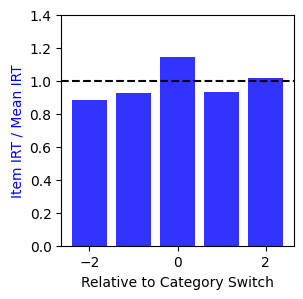

In [30]:
import matplotlib.pyplot as plt
from src.switch import get_mean_heuristic

mean_irt = get_mean_heuristic(hills, heuristic_col='irt', switch_col='switch_adj')

fig, ax1 = plt.subplots(figsize=(3, 3))
ax1.bar(range(-2, 3), mean_irt, color='b', alpha=0.8)
ax1.axhline(y=1, color='k', linestyle='--')
ax1.set_ylim(0, 1.4)
ax1.set_xlabel('Relative to Category Switch')
ax1.set_ylabel('Item IRT / Mean IRT', color='b')
plt.show()

### Category Switch Prediction

In [32]:
from src.switch import get_category_transitions
from src.search import sub_category_switch_step

transition_probs = get_category_transitions(hills)
sub_category_switch_step(G, 'dog', reba_categories, transition_probs)['cat']

0.1319958622759768

In [33]:
for i, run in enumerate(hills):
    cue_probs = [0]
    for j, r in enumerate(run['response'][1:]):
        next_node = sub_category_switch_step(G, run['response'][j-1], reba_categories, transition_probs)
        if run['response'][j] in next_node.keys():
            cue_probs += [next_node[run['response'][j]]]
        else:
            cue_probs += [float('nan')]
    hills[i]['sub_category_cue_probs'] = np.asarray(cue_probs)
    hills[i]['sub_category_cue_probs'] = right_shift(hills[i]['sub_category_cue_probs'])

In [210]:
from src.search import random_walk, random_walk_irt
import random

simulated_runs = []
for _ in range(100):
    walk, path = random_walk(RW, start_node=random.choice(list(RW.nodes())), max_length=1000, max_iter=4000, return_path=True)
    irt = []
    for exemplar in walk:
        irt += [random_walk_irt(path, exemplar)]
    categories = min_category_switches([reba_categories[r] for r in walk])
    switches = [categories[i-1] != categories[i] for i, c in enumerate(categories[1:])] + [False]
    simulated_runs += [{
        'response': walk,
        'path_length': irt,
        'switch_adj': switches
    }]

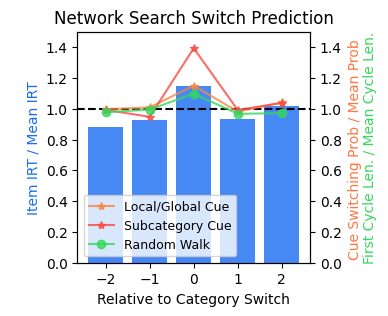

In [291]:
import matplotlib.pyplot as plt
from src.switch import get_mean_heuristic

mean_irt = get_mean_heuristic(hills, heuristic_col='irt', switch_col='switch_adj')
mean_hills = get_mean_heuristic(hills, heuristic_col='cue_probs', switch_col='switch_adj')
mean_sub_cue = get_mean_heuristic(hills, heuristic_col='sub_category_cue_probs', switch_col='switch_adj')
mean_random_walk = get_mean_heuristic(simulated_runs, heuristic_col='path_length', switch_col='switch_adj')

fig, ax1 = plt.subplots(figsize=(3, 3),)

ax1.bar(range(-2, 3), mean_irt, color='#186cf2', alpha=0.8)
ax1.axhline(y=1, color='k', linestyle='--')
ax1.set_xticks(range(-2, 3))
ax1.set_ylim(0, 1.5)
ax1.set_xlabel('Relative to Category Switch')
ax1.set_ylabel('\nItem IRT / Mean IRT', color='#186cf2')

ax2 = ax1.twinx()
# ax2.plot(range(-2, 3), mean_random_walk, color='#36d65e', marker='o', alpha=0.8, label='Random Walk')
ax2.plot(range(-2, 3), mean_hills, color='#fa8643', marker='*', alpha=0.8, label='Local + Global Cue')
ax2.plot(range(-2, 3), mean_sub_cue, color='#fa4a43', marker='*', alpha=0.8, label='L + G + Subcategory Cue')
ax2.set_ylim(0, 1.5)
ax2.set_ylabel('\n\nCue Switching Prob / Mean Prob \n', color='#ff7640')

ax3 = ax2.twinx()
for s in ax3.spines.keys():
    ax3.spines[s].set_visible(False)
ax2.set_yticks([])
ax3.spines['right'].set_position(('outward', 0))  
ax3.plot(range(-2, 3), mean_random_walk, color='#36d65e', marker='o', alpha=0.8, label='Random Walk')
ax3.set_ylabel('\nFirst Cycle Len. / Mean Cycle Len.', color='#36d65e')
ax3.set_ylim(0, 1.5)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
all_handles = handles1 + handles2 + handles3
all_labels = labels1 + labels2 + labels3

plt.title('Network Search Switch Prediction')
plt.legend(all_handles, all_labels, loc='lower left', fontsize=9)

out_filename = "img/subcategory_switch.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()